# Model Specification
This example solve a standard AR(1) process but with multiple noise measurements. If there are many parameters, we need more data for proper estimation.

In [1]:

import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from linkalman.core.utils import gen_PSD
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy
%matplotlib inline 



/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Unrestricted Parametrization of Covariance Matrices
Sometime we want to let a covariance matrix (e.g. `R`) to be fully parametrized without restriction (e.g. PSD of `R`). Here I use `linkalman.core.utils.gen_PSD` to achieve this. It uses Cholesky decomposition with strictly non-negative diagonal values to achieve unique and restriction-free parametrizaion.   

In [2]:
def my_f(theta):
    """
    AR(1) model. Introduce noise and 
    """
    # Define theta
    f = 1 / (1 + np.exp(theta[3]))
    sigma = np.exp(theta[4]) 
    # Generate F
    F = np.array([[f]])
    # Generate Q
    Q = np.array([[sigma]]) 
    # Generate R, set to 0 to be consistent with AR(1) process
    R = gen_PSD(theta[0:3], 2)  # need three parameters to define a 2-by-2 R
    # Generate H
    H = np.array([[1], [theta[5]]])  # enforce one coefficient to be 1 to make the system more identifiable.
    # Generate D
    D = np.array([[theta[6]], [theta[7]]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R, 'D': D}

    return M



In [3]:
def my_solver(param, obj_func, verbose=False, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    def disp_f(x):
        print('theta is {}. Function value is: {}.'.format(x, obj_func(x)))
    callbackf = None
    if verbose:
        callbackf = disp_f
    res = minimize(obj_, param, callback=callbackf, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1  # used to calculate stationary mean
model = BCM()
model.set_f(my_f, x_0=x * np.ones([1, 1]))
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-8, 'disp': True, 'maxiter': 10000}, verbose=False) 

# Generate Synthetic Data
Same as the standard setup, but I cross off some measurements during training period and see how `linkalman` handles them. I generate some partial missing data for each of the measurements.

In [5]:
# Some initial parameters
theta = np.array([0.1, 0.3, 0.1, -0.5, -0.1, 2, 4, 5])
T = 3000  
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  

missing_range_1st = [0.3, 0.4]  # range of missing for the first measurement
missing_range_2nd_end = 0.5  # end ratio of missing for the second measurement

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

# If we want AR(1) with non-zero stationary mean, we should proivde a constant 
x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  # use x to ensure constant model

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  
df['y_1_vis'] = df.y_1.copy()

# Insert some missingness
missing_start1_t = np.floor(T * missing_range_1st[0]).astype(int)
missing_end1_t = np.floor(T * missing_range_1st[1]).astype(int)
missing_start2_t = missing_end1_t 
missing_end2_t = np.floor(T * missing_range_2nd_end).astype(int)

is_missing1 = (df.index >= missing_start1_t) & (df.index < missing_end1_t)
is_missing2 = (df.index >= missing_end1_t) & (df.index < missing_end2_t)
df.loc[is_missing1, ['y_0']] = np.nan
df.loc[is_missing2, ['y_1']] = np.nan

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()
df_test = df.copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0', 'y_1']] = np.nan

# Fit and Predict

In [6]:

# Fit data using LLY:
start_time = datetime.datetime.now()
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')
end_time = datetime.datetime.now()
print('Runtime: {} seconds.'.format((end_time - start_time).seconds))

Optimization terminated successfully.
         Current function value: 7688.079428
         Iterations: 2907
         Function evaluations: 4386
Runtime: 571 seconds.


# Check Model Performance
Here I check filtered and smoothed estimates for both `y_0` and `y_1`

In [7]:
# Generate upper and lower bounds
# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['yf0_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['yf0_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['ys0_ub'] = df_LLY.y_0_smoothed + 1.96 * np.sqrt(df_LLY.y_0_svar)
df_LLY['ys0_lb'] = df_LLY.y_0_smoothed - 1.96 * np.sqrt(df_LLY.y_0_svar)

df_LLY['yf1_ub'] = df_LLY.y_1_filtered + 1.96 * np.sqrt(df_LLY.y_1_fvar)
df_LLY['yf1_lb'] = df_LLY.y_1_filtered - 1.96 * np.sqrt(df_LLY.y_1_fvar)
df_LLY['ys1_ub'] = df_LLY.y_1_smoothed + 1.96 * np.sqrt(df_LLY.y_1_svar)
df_LLY['ys1_lb'] = df_LLY.y_1_smoothed - 1.96 * np.sqrt(df_LLY.y_1_svar)


# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['yf0_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['yf0_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['ys0_ub'] = df_true.y_0_smoothed + 1.96 * np.sqrt(df_true.y_0_svar)
df_true['ys0_lb'] = df_true.y_0_smoothed - 1.96 * np.sqrt(df_true.y_0_svar)

df_true['yf1_ub'] = df_true.y_1_filtered + 1.96 * np.sqrt(df_true.y_1_fvar)
df_true['yf1_lb'] = df_true.y_1_filtered - 1.96 * np.sqrt(df_true.y_1_fvar)
df_true['ys1_ub'] = df_true.y_1_smoothed + 1.96 * np.sqrt(df_true.y_1_svar)
df_true['ys1_lb'] = df_true.y_1_smoothed - 1.96 * np.sqrt(df_true.y_1_svar)

def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

Here I plot the filtered and smoothed $y_t$, $\hat{\xi}_{t|T}$ and $\hat{\xi}_{t|t-1}$ from the fitted $\theta$. As you can see, the smoothed model produced a much narrower confidence interval around $\xi_t$.

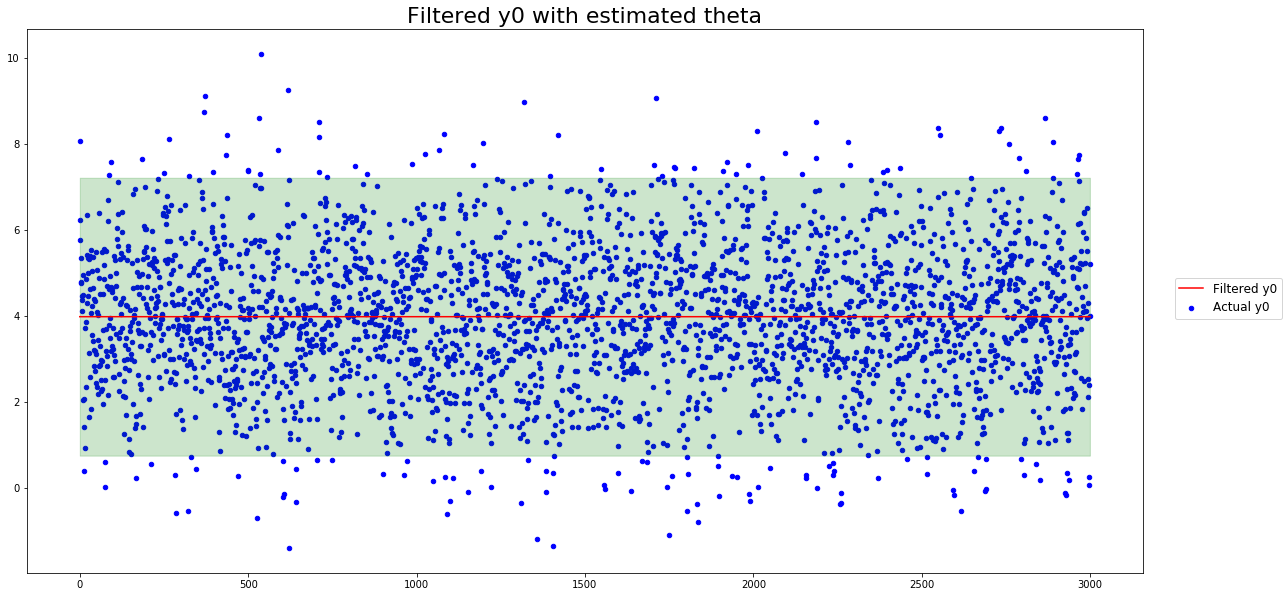

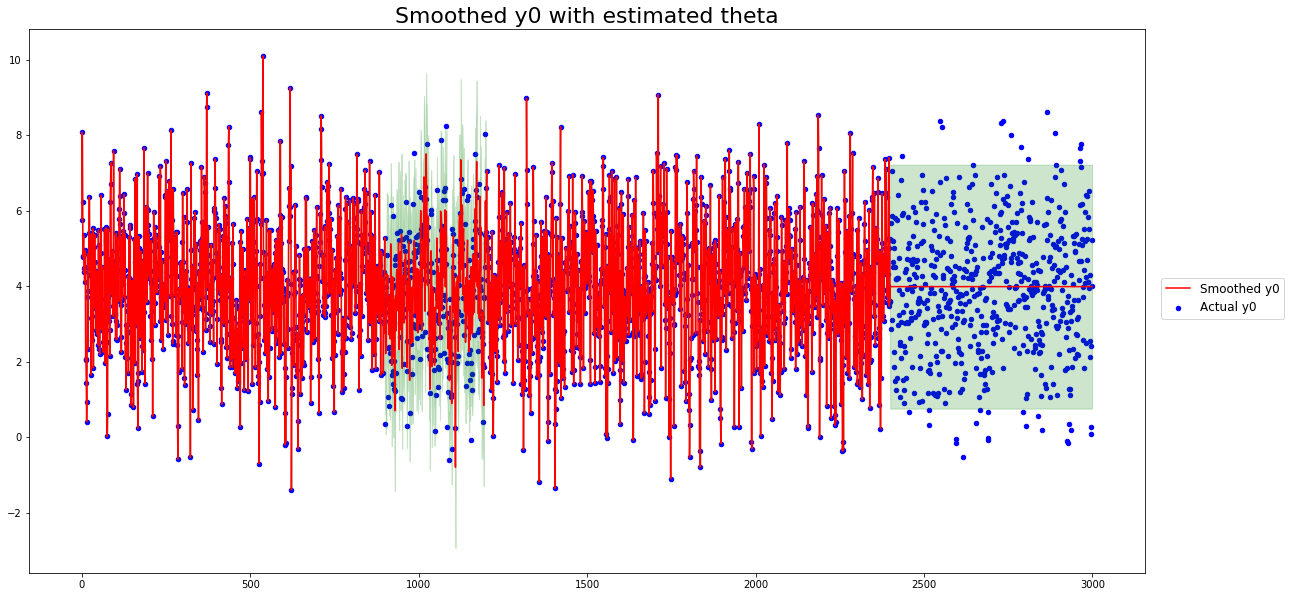

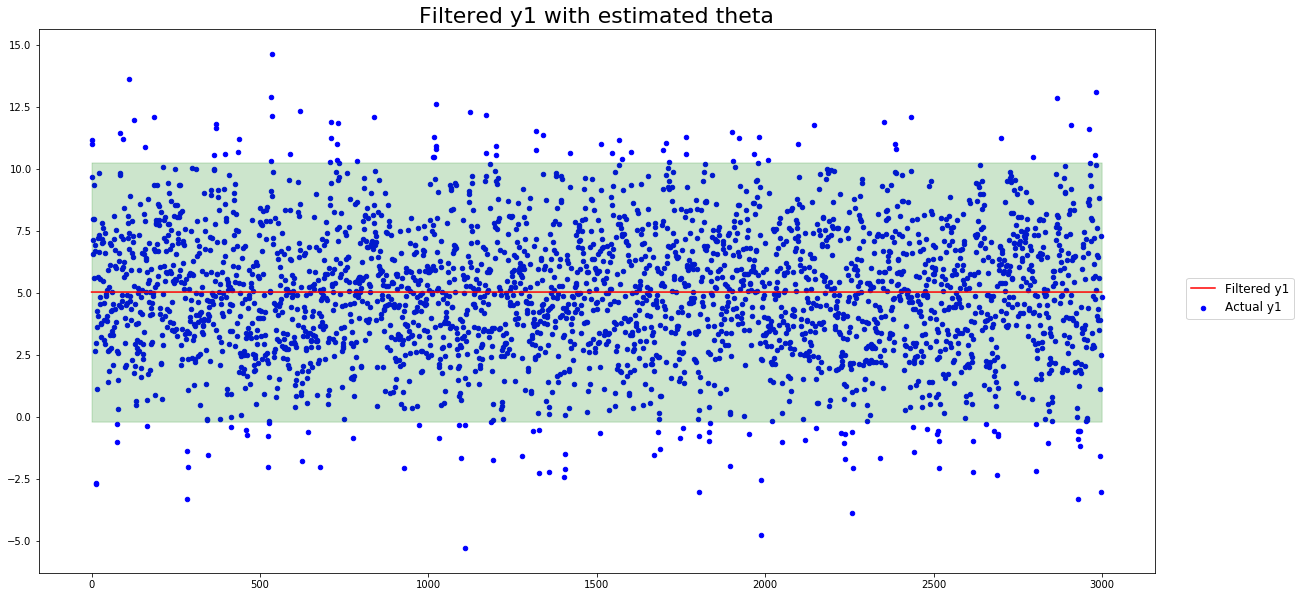

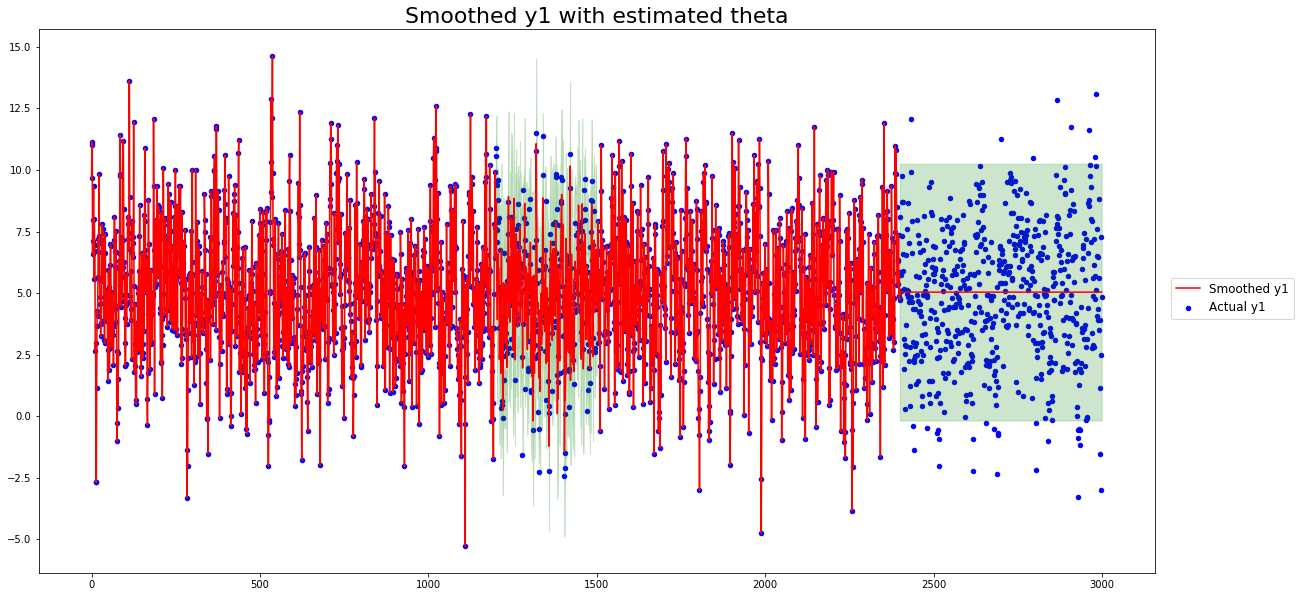

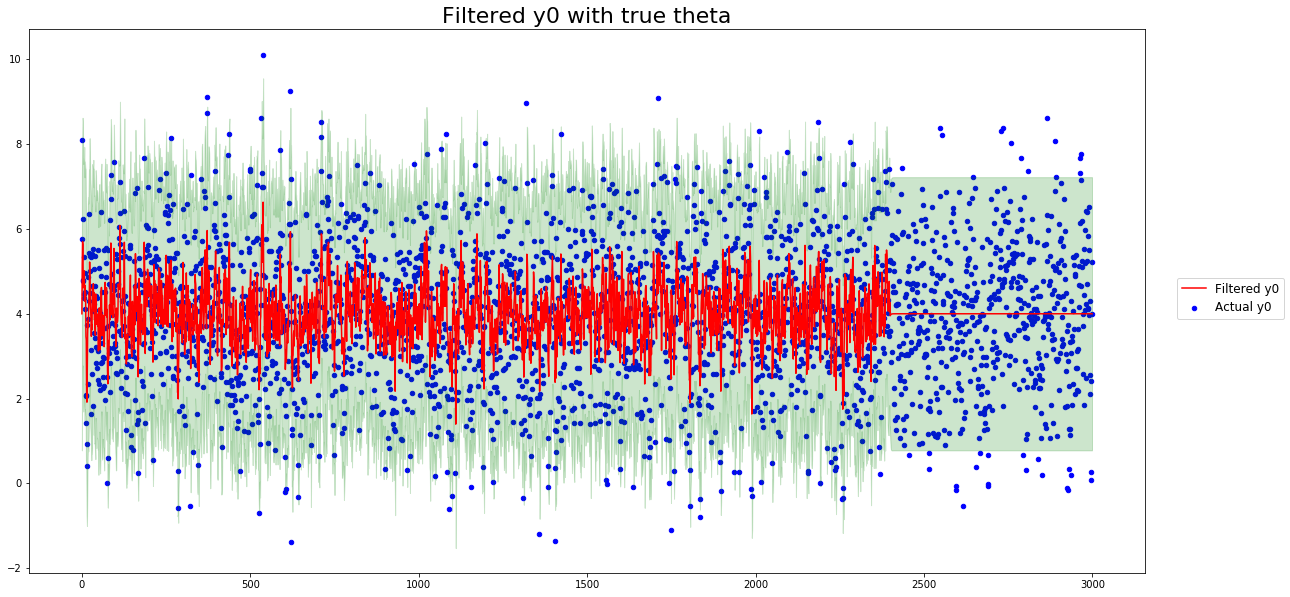

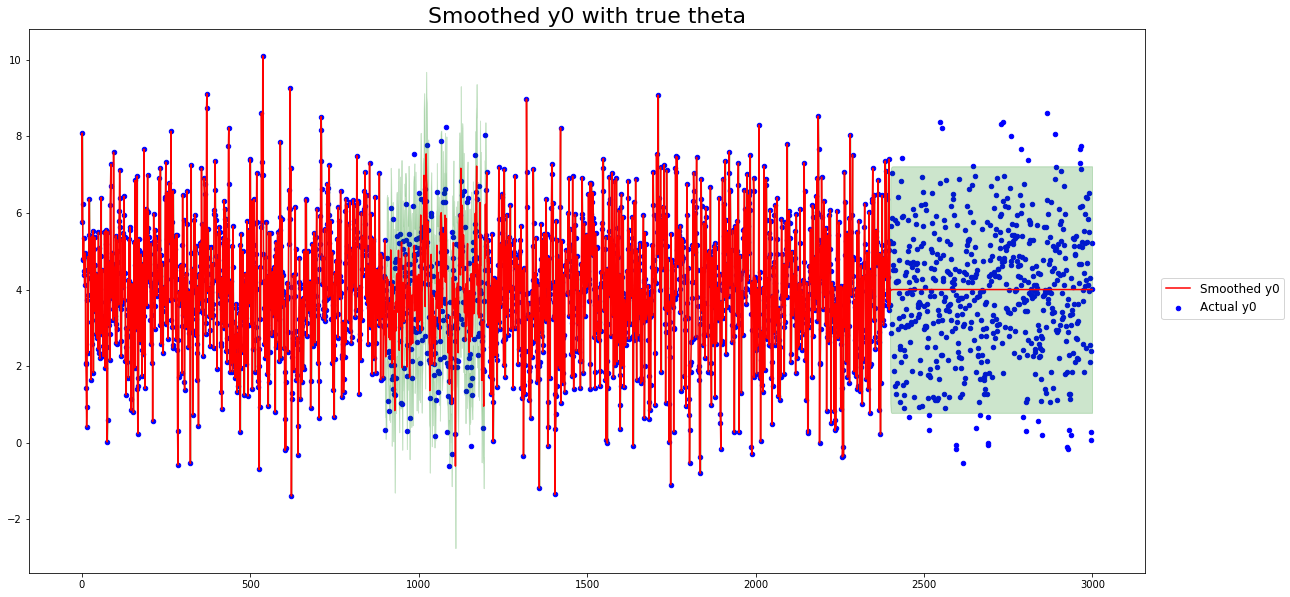

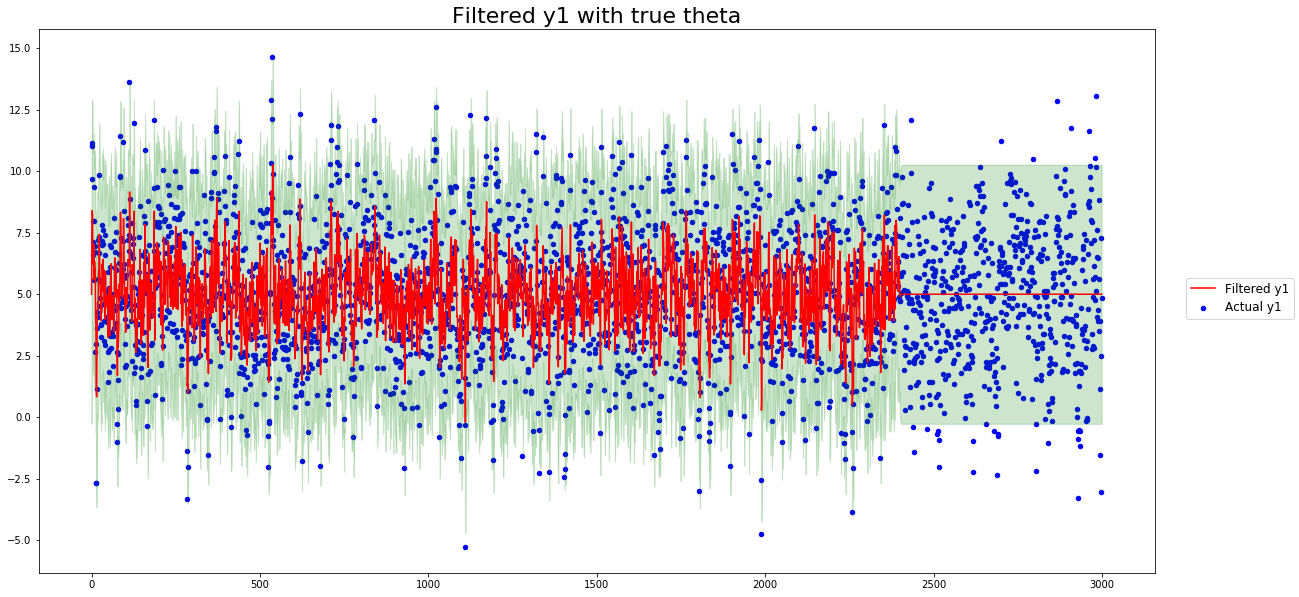

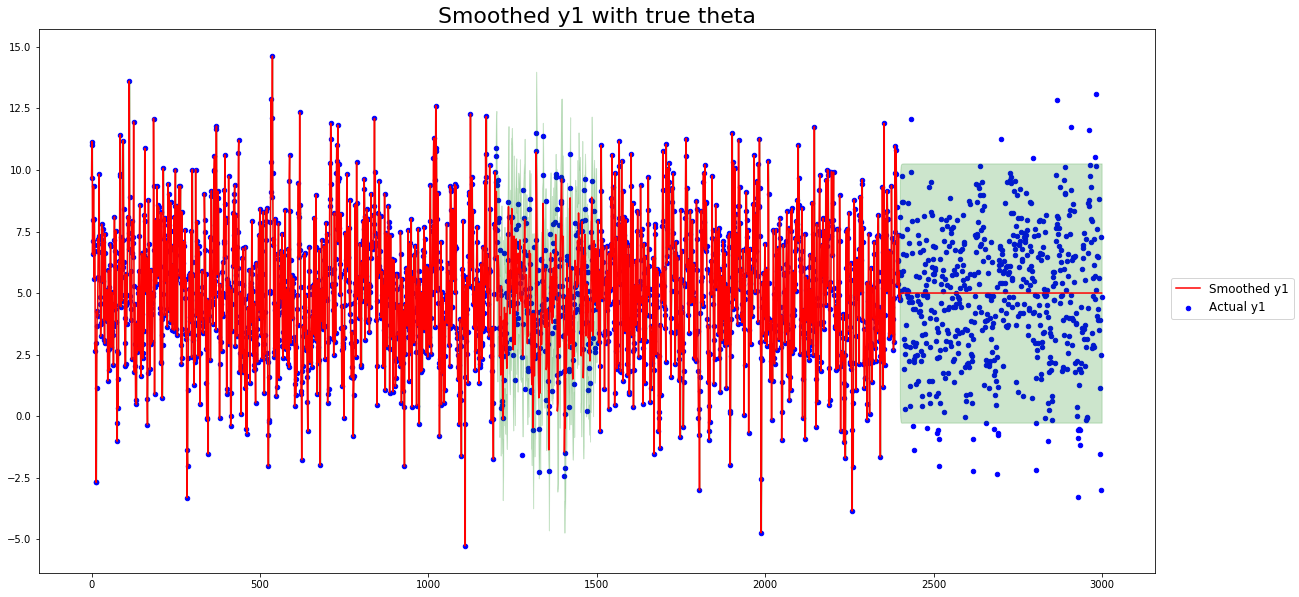

In [8]:
# y_0_t with estimated theta
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'yf0_ub', 'yf0_lb', 'Filtered y0', 'Actual y0',
           'Filtered y0 with estimated theta')
simple_plot(df_LLY, 'y_0_smoothed', 'y_0_vis', 'ys0_ub', 'ys0_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y0 with estimated theta')

# y_1_t with estimated theta
simple_plot(df_LLY, 'y_1_filtered', 'y_1_vis', 'yf1_ub', 'yf1_lb', 'Filtered y1', 'Actual y1',
           'Filtered y1 with estimated theta')
simple_plot(df_LLY, 'y_1_smoothed', 'y_1_vis', 'ys1_ub', 'ys1_lb', 'Smoothed y1', 'Actual y1',
           'Smoothed y1 with estimated theta')

# y_0_t with true theta
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'yf0_ub', 'yf0_lb', 'Filtered y0', 'Actual y0',
           'Filtered y0 with true theta')
simple_plot(df_true, 'y_0_smoothed', 'y_0_vis', 'ys0_ub', 'ys0_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y0 with true theta')

# y_1_t with true theta
simple_plot(df_true, 'y_1_filtered', 'y_1_vis', 'yf1_ub', 'yf1_lb', 'Filtered y1', 'Actual y1',
           'Filtered y1 with true theta')
simple_plot(df_true, 'y_1_smoothed', 'y_1_vis', 'ys1_ub', 'ys1_lb', 'Smoothed y1', 'Actual y1',
           'Smoothed y1 with true theta')

In [9]:
# Build a simple function
def summary_stats(df, col_est, col_true):
    RMSE = np.sqrt((df[col_est] - df[col_true]).var())
    mean_error = (df[col_est] - df[col_true]).mean()
    return {'RMSE': RMSE, 'mean_error': mean_error}

In [10]:
# Compare model performance in training data
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_0_filtered', 'y_0_vis')))
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_1_filtered', 'y_1_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_1_filtered', 'y_1_vis')))
print('LLY theta for training data (smoothed): {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_smoothed', 'y_0_vis')))
print('Ture theta for training data (smoothed): {}'.format(
    summary_stats(df_true[is_train], 'y_0_smoothed', 'y_0_vis')))
print('LLY theta for training data (smoothed): {}'.format(
    summary_stats(df_LLY[is_train], 'y_1_smoothed', 'y_1_vis')))
print('Ture theta for training data (smoothed): {}'.format(
    summary_stats(df_true[is_train], 'y_1_smoothed', 'y_1_vis')))

LLY theta for training data: {'RMSE': 1.6503080097831941, 'mean_error': 0.00784549872005923}
Ture theta for training data: {'RMSE': 1.4878845634526698, 'mean_error': 0.022165978903081265}
LLY theta for training data: {'RMSE': 2.656458782129862, 'mean_error': -0.01558984895228709}
Ture theta for training data: {'RMSE': 2.2578884579470233, 'mean_error': -0.04325664897648061}
LLY theta for training data (smoothed): {'RMSE': 0.43939572281782974, 'mean_error': 0.007846145336410225}
Ture theta for training data (smoothed): {'RMSE': 0.4372483078774843, 'mean_error': 0.010846299411023483}
LLY theta for training data (smoothed): {'RMSE': 0.6592532585511841, 'mean_error': -0.015588722441377273}
Ture theta for training data (smoothed): {'RMSE': 0.6135408192781124, 'mean_error': -0.03573443258010535}


In [11]:
# Compare model performance in test data
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_0_filtered', 'y_0_vis')))
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_1_filtered', 'y_1_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_1_filtered', 'y_1_vis')))

LLY theta for test data: {'RMSE': 1.634124598025247, 'mean_error': 0.06666129732398633}
Ture theta for test data: {'RMSE': 1.4929225010508118, 'mean_error': 0.03472714125372602}
LLY theta for test data: {'RMSE': 2.7040132059224846, 'mean_error': 0.19906669770835866}
Ture theta for test data: {'RMSE': 2.323352108970553, 'mean_error': 0.07889094652731456}


In [12]:
# Compare model performance in forecast data
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_1_filtered', 'y_1_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_1_filtered', 'y_1_vis')))

LLY theta for forecast data: {'RMSE': 1.697826720021161, 'mean_error': 0.06413997027156505}
Ture theta for forecast data: {'RMSE': 1.6978724534330838, 'mean_error': 0.07379323338504874}
LLY theta for forecast data: {'RMSE': 2.7698339010569013, 'mean_error': 0.16610247779774143}
Ture theta for forecast data: {'RMSE': 2.769999848837521, 'mean_error': 0.12910124822864147}


In [13]:
my_f(theta)

{'F': array([[0.62245933]]), 'Q': array([[0.90483742]]), 'H': array([[1.],
        [2.]]), 'R': array([[1.22140276, 0.33155128],
        [0.33155128, 1.31140276]]), 'D': array([[4.],
        [5.]])}

In [14]:
my_f(model.theta_opt)

{'F': array([[0.46712141]]),
 'Q': array([[3.73852947e-06]]),
 'H': array([[ 1.        ],
        [-0.32418557]]),
 'R': array([[2.71806574, 3.28898077],
        [3.28898077, 7.08730337]]),
 'D': array([[3.99014824],
        [5.03660424]])}